In [7]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.00967}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.00980},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.01043},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.01130},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.01217},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.01317},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.01399},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.01478},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.01560},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.01637}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.01652, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.02019, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.02319, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.02577, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.02995, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.03395, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.03753, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.03873, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.03975, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}



In [8]:
# Problem 2a - Fitting a ZCB term structure to the market data.
mesh = 1/12
M = 360
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*mesh for i in range(0,M+1)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)



In [9]:
# Forward 6M EURIBOR rates
alpha = 0.5
T_6M = np.array([i*alpha for i in range(0,61)])
p_6M = fid.for_values_in_list_find_value_return_value(T_6M,T_inter,p_inter)
L_forward_6M = fid.forward_rates_from_zcb_prices(T_6M,p_6M,horizon = 1,method = "simple")


In [10]:
# 5Y forward term structure of interest rates
S = 2
T_2Y_forward = np.array([i*mesh for i in range(0,M+1-S*12)])
p_2Y_forward = fid.for_values_in_list_find_value_return_value(np.array([i*mesh for i in range(S*12,M+1)]),T_inter,p_inter)/p_inter[S*12]
R_2Y_forward = fid.spot_rates_from_zcb_prices(T_2Y_forward,p_2Y_forward)


5Y swap before changes. S_5Y_swap: 4.688311500676128, R_5Y_swap: 0.025770000000081925
5Y swap after shift in all ZCB spot rates. S_5Y_swap: 4.686932677419535, R_5Y_swap: 0.025871348479965604, DV01: -0.04750135021736117
5Y swap after shift in only 5Y ZCB spot rate. S_5Y_swap: 4.6878720194492765, R_5Y_swap: 0.025866164455126087, DV01: -0.04508066580671118


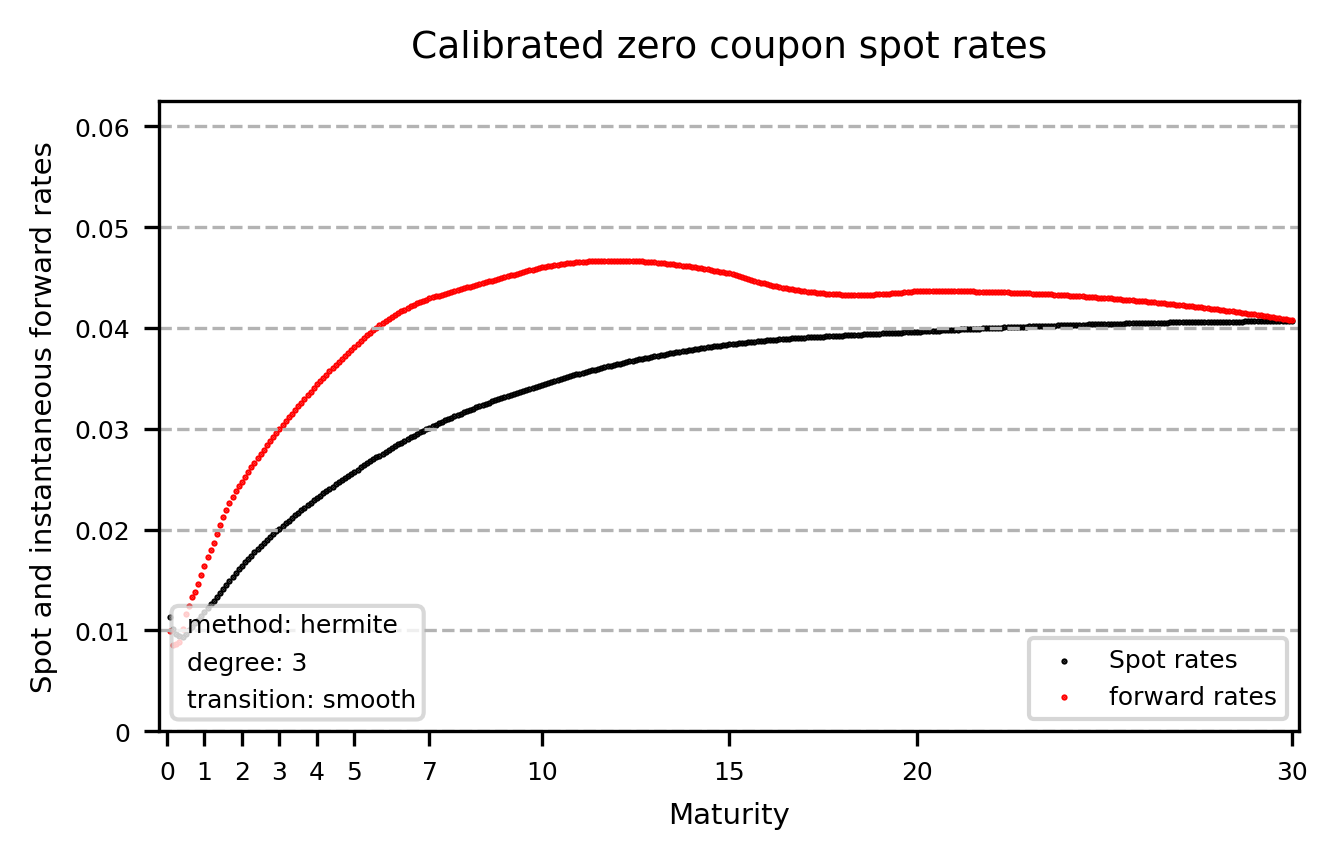

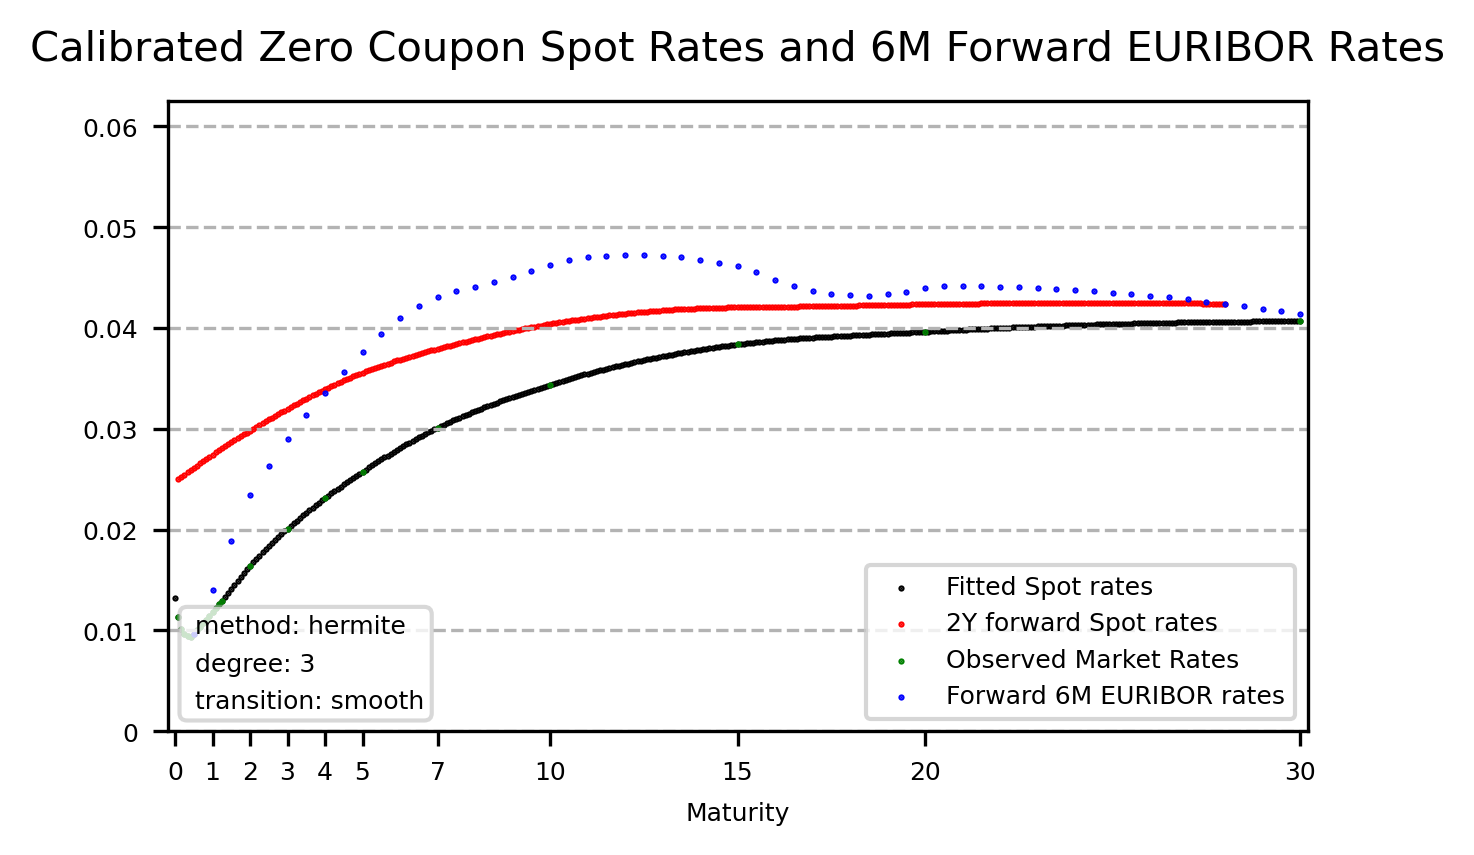

In [12]:
# 5Y interest rate swap before shift
T_5Y_swap_fixed_leg = np.array([i for i in range(0,6)])
p_5Y_swap_fixed_leg = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter))
S_5Y_swap = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg[i]
R_5Y_swap = (1-p_5Y_swap_fixed_leg[-1])/S_5Y_swap
print(f"5Y swap before changes. S_5Y_swap: {S_5Y_swap}, R_5Y_swap: {R_5Y_swap}")


# Shifting the entire spot rate zcb_curve
R_inter_zcb_shift = R_inter + np.array([0] + [0.0001 for i in range(1,len(R_inter))])
p_inter_zcb_shift = fid.zcb_prices_from_spot_rates(T_inter,R_inter_zcb_shift)
p_5Y_swap_fixed_leg_zcb_shift = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter_zcb_shift))
S_5Y_swap_zcb_shift = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap_zcb_shift += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg_zcb_shift[i]
R_5Y_swap_zcb_shift = (1-p_5Y_swap_fixed_leg_zcb_shift[-1])/S_5Y_swap_zcb_shift
print(f"5Y swap after shift in all ZCB spot rates. S_5Y_swap: {S_5Y_swap_zcb_shift}, R_5Y_swap: {R_5Y_swap_zcb_shift}, DV01: {S_5Y_swap_zcb_shift*(R_5Y_swap-R_5Y_swap_zcb_shift)*100}")


# Shifting only the 5Y zcb rate
R_bump_5Y = np.zeros([len(R_inter)])
R_bump_5Y[60] = 0.0001
R_inter_5Y_shift = R_inter + R_bump_5Y
p_inter_5Y_shift = fid.zcb_prices_from_spot_rates(T_inter,R_inter_5Y_shift)
p_5Y_swap_fixed_leg_5Y_shift = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter_5Y_shift))
S_5Y_swap_5Y_shift = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap_5Y_shift += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg_5Y_shift[i]
R_5Y_swap_5Y_shift = (1-p_5Y_swap_fixed_leg_5Y_shift[-1])/S_5Y_swap_5Y_shift
print(f"5Y swap after shift in only 5Y ZCB spot rate. S_5Y_swap: {S_5Y_swap_5Y_shift}, R_5Y_swap: {R_5Y_swap_5Y_shift}, DV01: {S_5Y_swap_5Y_shift*(R_5Y_swap-R_5Y_swap_5Y_shift)*100}")


fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 7)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
ax.set_ylabel(f"Spot and instantaneous forward rates",fontsize = 7)
plt.grid(axis = 'y', which='major', color = (0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/yield_curve_fit.pdf")
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated Zero Coupon Spot Rates and 6M Forward EURIBOR Rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Fitted Spot rates")
p2 = ax.scatter(T_2Y_forward, R_2Y_forward, s = 1, color = 'red', marker = ".",label="2Y forward Spot rates")
p3 = ax.scatter(T_fit, R_fit, s = 1, color = 'green', marker = ".",label="Observed Market Rates")
p4 = ax.scatter(T_6M, L_forward_6M, s = 1, color = 'blue', marker = ".",label="Forward 6M EURIBOR rates")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0023,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0023,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)

plt.show()
